<a href="https://colab.research.google.com/github/robgon-art/open-clip/blob/main/Test_LOC_Photos_with_OpenCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Library of Congress Photos with OpenCLIP

This is a self-contained notebook that shows how to download and run OpenCLIP models and calculate the similarity between image and text inputs. This is based on the Colab, [here](https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_clip.ipynb)

In [1]:
!pip install open_clip_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which 

In [2]:
import numpy as np
import torch
from pkg_resources import packaging
print("Torch version:", torch.__version__)

Torch version: 1.13.1+cu116


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32-quickgelu', 'openai'),
 ('ViT-B-32-quickgelu', 'laion400m_e31'),
 ('ViT-B-32-quickgelu', 'laion400m_e32'),
 ('ViT-B-16', 'openai'),
 ('ViT-B-16', 'laion400m_e31'),
 ('ViT-B-16', 'laion400m_e32'),
 ('ViT-B-16', 'laion2b_s34b_b88k'),
 ('ViT-B-16-plus-240', 'laion400m_e31'),
 ('ViT-B-16-plus-240', 'laion400m_e32'),
 ('ViT-L-14', 'openai'),
 ('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion400m_e32'),
 ('ViT-L-14', 'laion2b_s32b_b82k'),
 ('ViT-L-14-336', 'openai'),
 ('ViT-H-14', 'laion2b_s32b_

In [4]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16')
model.cuda().eval()

100%|███████████████████████████████████████| 605M/605M [01:28<00:00, 6.86MiB/s]


CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
        (1): ResidualAttentionBlock(
          (l

# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7feccb60bf70>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
from open_clip import tokenizer
tokenizer.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Get input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

In [7]:
data = [
["https://live.staticflickr.com/3382/3450316006_39e4a593da.jpg", "photos/3450316006_39e4a593da.jpg", "Mary, Queen of Scots"],
["https://live.staticflickr.com/65535/50837950597_754b8934ea.jpg", "photos/50837950597_754b8934ea.jpg", "Thirteen men doing acrobatics"],
["https://live.staticflickr.com/2281/2179906006_b7043bfe83.jpg", "photos/2179906006_b7043bfe83.jpg", "Japanese-American camp, war emergency evacuation,Tule Lake Relocation Center, Newell, Calif."],
["https://live.staticflickr.com/3093/3252917783_e81308e684.jpg", "photos/3252917783_e81308e684.jpg", "Abraham Lincoln, candidate for U.S. president. Half-length portrait, seated, facing front"],
["https://live.staticflickr.com/2356/2179146850_3fc259c7f0.jpg", "photos/2179146850_3fc259c7f0.jpg", "Jack Whinery, homesteader, with his wife and the youngest of his five children, Pie Town, New Mexico"],
["https://live.staticflickr.com/65535/48346177956_26a950b9e2.jpg", "photos/48346177956_26a950b9e2.jpg", "Pete Seeger at Library of Congress Bicentennial"]
]

In [8]:
import urllib.request
import textwrap
import os

path_names = []
descriptions = []

# Create a folder to save the photos
folder = "photos"
if not os.path.exists(folder):
  os.makedirs(folder)

for d in data:
  # Retrieve the list of photos
  url = d[0]
  caption = d[2]
  caption = caption.replace("(LOC)", "").replace("[", "").replace("]","").strip()
  path_name = d[1]
  urllib.request.urlretrieve(url, path_name)
  path_names.append(path_name)
  descriptions.append(caption)
  print(url, path_name, caption)

https://live.staticflickr.com/3382/3450316006_39e4a593da.jpg photos/3450316006_39e4a593da.jpg Mary, Queen of Scots
https://live.staticflickr.com/65535/50837950597_754b8934ea.jpg photos/50837950597_754b8934ea.jpg Thirteen men doing acrobatics
https://live.staticflickr.com/2281/2179906006_b7043bfe83.jpg photos/2179906006_b7043bfe83.jpg Japanese-American camp, war emergency evacuation,Tule Lake Relocation Center, Newell, Calif.
https://live.staticflickr.com/3093/3252917783_e81308e684.jpg photos/3252917783_e81308e684.jpg Abraham Lincoln, candidate for U.S. president. Half-length portrait, seated, facing front
https://live.staticflickr.com/2356/2179146850_3fc259c7f0.jpg photos/2179146850_3fc259c7f0.jpg Jack Whinery, homesteader, with his wife and the youngest of his five children, Pie Town, New Mexico
https://live.staticflickr.com/65535/48346177956_26a950b9e2.jpg photos/48346177956_26a950b9e2.jpg Pete Seeger at Library of Congress Bicentennial


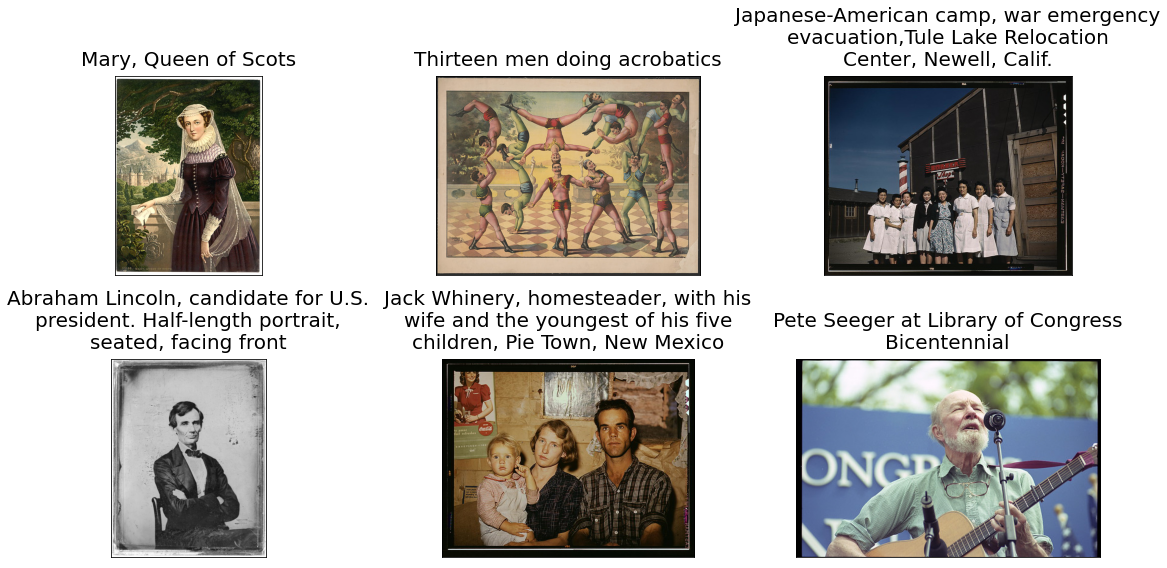

In [9]:
import matplotlib.pyplot as plt
import skimage
from PIL import Image
import textwrap

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 8))

for path_name, description in list(zip(path_names, descriptions)):
  image = Image.open(path_name).convert("RGB")
  plt.subplot(2, 3, len(images) + 1)
  plt.imshow(image)
  description_wrapped = "\n".join(textwrap.wrap(description, width=38))
  plt.title(description_wrapped, size=20, y=1.025)
  plt.xticks([])
  plt.yticks([])

  original_images.append(image)
  images.append(preprocess(image))

plt.tight_layout()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [10]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = tokenizer.tokenize(descriptions).cuda()

In [11]:
with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [12]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

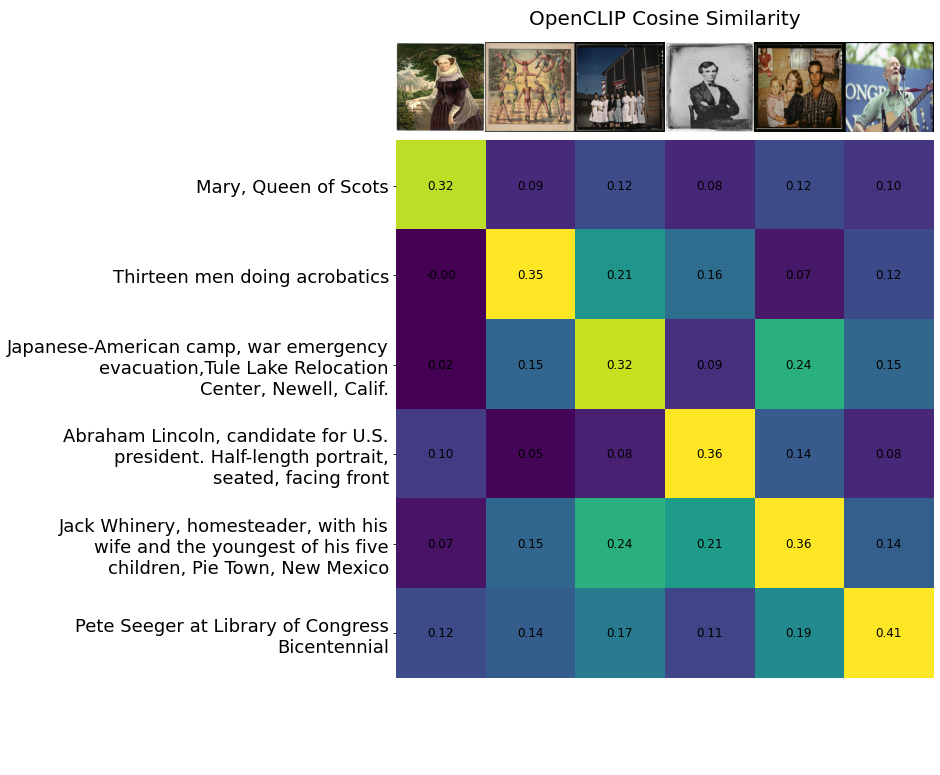

In [13]:
count = len(descriptions)

wrapped_descriptions = []
for d in descriptions:
  description_wrapped = "\n".join(textwrap.wrap(d, width=38))
  wrapped_descriptions.append(description_wrapped)

fig, ax = plt.subplots(1, 1, figsize=(20, 14))
plt.imshow(similarity, vmin=0.05, vmax=0.35)
plt.yticks(range(count), wrapped_descriptions, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

ax.set_title('OpenCLIP Cosine Similarity', y=0.995, pad=-14 , size=20)
plt.show()